In [455]:
!pip install tweepy

Defaulting to user installation because normal site-packages is not writeable


In [456]:
import numpy as np # linear algebra
import pandas as pd # data processing
import os
import tweepy as tw #for accessing Twitter API


#For Preprocessing
import re    # RegEx for removing non-letter characters
import nltk  #natural language processing
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *

# For Building the model
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns

#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

pd.options.plotting.backend = "plotly"

[nltk_data] Downloading package stopwords to /home/ensai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [457]:
import os

# Définir le chemin vers le dossier du dataset
dataset_dir = './twitter-airline-sentiment'
kaggle_dest = os.path.expanduser('~/.kaggle')
kaggle_json_path = os.path.join(kaggle_dest, 'kaggle.json')

# Vérifier si le dossier twitter-airline-sentiment existe
if not os.path.exists(dataset_dir):
    # Créer le dossier .kaggle et placer votre fichier kaggle.json (API token) si nécessaire
    os.makedirs(kaggle_dest, exist_ok=True)
    
    if not os.path.exists(kaggle_json_path):
        os.system('cp kaggle.json ~/.kaggle/')
        os.system('chmod 600 ~/.kaggle/kaggle.json')

    # Télécharger le dataset "car-brand-recognition" depuis Kaggle

    #https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment
    username = 'crowdflower'
    dataset_name = 'twitter-airline-sentiment'
    os.system(f'kaggle datasets download -d {username}/{dataset_name}')

    # Créer le dossier pour la décompression
    os.makedirs(dataset_dir, exist_ok=True)

    # Décompresser le fichier zip téléchargé dans le dossier twitter-airline-sentiment
    os.system(f'unzip -q {dataset_name}.zip -d {dataset_dir}')

    print("Le dataset a été téléchargé et décompressé.")
else:
    print("Le dossier twitter-airline-sentimentexiste déjà. Aucune action n'a été effectuée.")

Le dossier twitter-airline-sentimentexiste déjà. Aucune action n'a été effectuée.


## Exploratory Data Analysis

### Cleaning and prepping dataset

In [458]:

data = pd.read_csv('twitter-airline-sentiment/Tweets.csv')

data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [459]:
data.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [460]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [461]:
data.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

## **Preprocessing**

In [462]:
data['tweet_date'] = pd.to_datetime(data['tweet_created']).dt.date


In [463]:
# nombre de tweet par date 
nb_twt_date = data.groupby('tweet_date').size()

In [464]:
import pandas as pd

# Affichage du pourcentage de valeurs manquantes par colonne dans le DataFrame
print("Percentage of null or na values in each column of df:")
missing_percentage = (data.isna().sum() / len(data) * 100).round(2)
print(missing_percentage.sort_values(ascending=False))


Percentage of null or na values in each column of df:
negativereason_gold             99.78
airline_sentiment_gold          99.73
tweet_coord                     93.04
negativereason                  37.31
user_timezone                   32.92
tweet_location                  32.33
negativereason_confidence       28.13
tweet_id                         0.00
airline_sentiment                0.00
airline_sentiment_confidence     0.00
airline                          0.00
name                             0.00
retweet_count                    0.00
text                             0.00
tweet_created                    0.00
tweet_date                       0.00
dtype: float64


In [465]:
import plotly.express as px
import pandas as pd

# Calcul du pourcentage de valeurs manquantes par colonne
missing_percentage = (data.isna().sum() / len(data) * 100).round(2)
missing_percentage = missing_percentage.reset_index()
missing_percentage.columns = ['column', 'missing_percentage']

# Création du graphique à barres avec Plotly Express
fig = px.bar(missing_percentage, 
             x='column', 
             y='missing_percentage', 
             title='Percentage of Missing Values by Column in DataFrame',
             labels={'missing_percentage': '% of Missing Values', 'column': 'Column'},
             text='missing_percentage')

fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', xaxis_tickangle=-45)

# Afficher le graphique
fig.show()


In [466]:
data.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone', 'tweet_date'],
      dtype='object')

In [467]:
del data['tweet_coord']
del data['airline_sentiment_gold']
del data['negativereason_gold']


### Analyse exploratoire

In [468]:
import plotly.express as px
import pandas as pd

# Comptage des différents types de sentiments
counter = data['airline_sentiment'].value_counts().reset_index()
counter.columns = ['Sentiment', 'Nombre']

# Création d'un graphique à barres avec Plotly Express
fig = px.bar(counter, 
             x='Sentiment', 
             y='Nombre',
             text='Nombre',
             color='Sentiment',  # Utilise la colonne 'Sentiment' pour la couleur
             color_discrete_map={'negative': 'red', 'neutral': 'blue', 'positive': 'green'},  # Couleurs personnalisées
             title='Nombre de sentiments par type')

# Mise à jour des labels et des titres
fig.update_layout(
    xaxis_title='Type de sentiment',
    yaxis_title='Nombre de sentiments',
    xaxis_tickangle=0,  # Ajustement de l'angle des étiquettes de l'axe x
    plot_bgcolor='white'  # Couleur de fond du graphique
)

# Mise à jour du texte des barres pour qu'il apparaisse à l'extérieur des barres
fig.update_traces(textposition='outside')

# Affichage du graphique
fig.show()


In [469]:
# Extraction des compagnies aériennes uniques
airlines = data['airline'].unique()

# Affichage de la liste des compagnies aériennes
print("Liste des compagnies aériennes :", airlines)


Liste des compagnies aériennes : ['Virgin America' 'United' 'Southwest' 'Delta' 'US Airways' 'American']


In [470]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots



# Création d'un subplot avec 2 lignes et 3 colonnes
fig = make_subplots(rows=2, cols=3, subplot_titles=[f'Sentiments pour {airline}' for airline in airlines])

# Itérer sur chaque compagnie aérienne pour créer un graphique à barres
for idx, airline in enumerate(airlines):
    # Filtrer les données pour chaque compagnie aérienne
    new_df = data[data['airline'] == airline]
    # Compter les sentiments
    count = new_df['airline_sentiment'].value_counts()
    # Créer un graphique à barres pour chaque compagnie aérienne
    fig.add_trace(
        go.Bar(x=['négatif', 'neutre', 'positif'],
               y=[count.get('negative', 0), count.get('neutral', 0), count.get('positive', 0)],
               name=airline,
               marker_color=['red', 'blue', 'green']), # Couleurs pour chaque sentiment
        row=(idx // 3) + 1, # Déterminer la ligne du subplot
        col=(idx % 3) + 1   # Déterminer la colonne du subplot
    )

# Mise à jour des titres et étiquettes
fig.update_layout(
    title_text='Nombre de sentiments pour chaque compagnie aérienne',
    height=800,  # Hauteur du graphique
    showlegend=False  # Masquer la légende car les titres des subplots sont explicites
)

# Afficher le graphique
fig.show()


In [471]:
import plotly.express as px
import pandas as pd

# Calcul des tweets négatifs pour chaque compagnie aérienne
neg_tweets = data[data['airline_sentiment'] == 'negative'].groupby('airline').size()

# Calcul du total des tweets pour chaque compagnie aérienne
total_tweets = data.groupby('airline').size()

# Calcul du pourcentage des tweets négatifs par rapport au total
percentage_neg = (neg_tweets / total_tweets * 100).reset_index()
percentage_neg.columns = ['Compagnie Aérienne', 'Pourcentage de Tweets Négatifs']

# Création d'un graphique à barres avec Plotly Express
fig = px.bar(percentage_neg,
             x='Compagnie Aérienne',
             y='Pourcentage de Tweets Négatifs',
             text='Pourcentage de Tweets Négatifs',
             color='Pourcentage de Tweets Négatifs',
             color_continuous_scale=px.colors.sequential.Plasma)

# Mise à jour des titres et étiquettes
fig.update_layout(
    title='Pourcentage de Tweets Négatifs par Compagnie Aérienne',
    xaxis_title='Compagnie Aérienne',
    yaxis_title='Pourcentage de Tweets Négatifs',
    plot_bgcolor='white'
)

# Mise à jour du texte des barres pour qu'il apparaisse à l'extérieur des barres
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')

# Afficher le graphique
fig.show()


In [472]:
# Calcul du maximum, minimum, et de la moyenne
max_neg = percentage_neg['Pourcentage de Tweets Négatifs'].max()
min_neg = percentage_neg['Pourcentage de Tweets Négatifs'].min()
mean_neg = percentage_neg['Pourcentage de Tweets Négatifs'].mean()

# Identification de la compagnie avec le plus et le moins de critiques négatives
worst_airline = percentage_neg.loc[percentage_neg['Pourcentage de Tweets Négatifs'].idxmax(), 'Compagnie Aérienne']
best_airline = percentage_neg.loc[percentage_neg['Pourcentage de Tweets Négatifs'].idxmin(), 'Compagnie Aérienne']

# Interprétation et conclusion
conclusion = f"""
Analyse des Sentiments des Tweets pour les Compagnies Aériennes:
- La compagnie aérienne avec le plus haut pourcentage de tweets négatifs est {worst_airline} avec {max_neg:.2f}%.
- La compagnie aérienne avec le plus bas pourcentage de tweets négatifs est {best_airline} avec {min_neg:.2f}%.
- En moyenne, {mean_neg:.2f}% des tweets sur les compagnies aériennes sont négatifs.

Conclusions:
- {worst_airline} pourrait nécessiter d'examiner les raisons derrière ces retours négatifs pour améliorer la satisfaction des clients.
- {best_airline} semble mieux perçue par sa clientèle comparativement aux autres.
- Les compagnies aériennes devraient continuer à surveiller les retours clients pour améliorer leurs services et réduire les avis négatifs.
"""

print(conclusion)


Analyse des Sentiments des Tweets pour les Compagnies Aériennes:
- La compagnie aérienne avec le plus haut pourcentage de tweets négatifs est US Airways avec 77.69%.
- La compagnie aérienne avec le plus bas pourcentage de tweets négatifs est Virgin America avec 35.91%.
- En moyenne, 57.59% des tweets sur les compagnies aériennes sont négatifs.

Conclusions:
- US Airways pourrait nécessiter d'examiner les raisons derrière ces retours négatifs pour améliorer la satisfaction des clients.
- Virgin America semble mieux perçue par sa clientèle comparativement aux autres.
- Les compagnies aériennes devraient continuer à surveiller les retours clients pour améliorer leurs services et réduire les avis négatifs.



In [473]:
import plotly.express as px
import pandas as pd

# Calcul du nombre de tweets par compagnie aérienne et par sentiment
figure_2 = data.groupby(['airline', 'airline_sentiment']).size().reset_index(name='count')

# Création d'un graphique à barres avec Plotly Express
fig = px.bar(figure_2,
             x='airline',
             y='count',
             color='airline_sentiment',
             text='count',
             title='Répartition des Sentiments par Compagnie Aérienne',
             labels={'airline': 'Compagnie Aérienne', 'count': 'Nombre de Tweets', 'airline_sentiment': 'Sentiment'},
             color_discrete_map={'negative': 'red', 'neutral': 'blue', 'positive': 'green'},  # Définition des couleurs
             height=600)

# Mise à jour du mode des barres pour les afficher côte à côte
fig.update_layout(
    barmode='group',
    xaxis={'categoryorder':'total descending'},  # Trie les compagnies aériennes par le nombre total de tweets
    plot_bgcolor='white',
    xaxis_title='Compagnie Aérienne',
    yaxis_title='Nombre de Tweets',
    legend_title='Sentiment'
)

# Mise à jour du texte des barres pour qu'il apparaisse à l'extérieur des barres
fig.update_traces(texttemplate='%{text}', textposition='outside')

# Afficher le graphique
fig.show()


### Analyse des Raisons Négatives

In [474]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import plotly.express as px

def obtenir_comptages_raisons(airline='All'):
    if airline == 'All':
        filtered_data = data
    else:
        filtered_data = data[data['airline'] == airline]
    
    filtered_data = filtered_data[filtered_data['negativereason'].notna()]
    reason_counts = filtered_data['negativereason'].value_counts().reset_index()
    reason_counts.columns = ['Raison', 'Nombre']
    return reason_counts

In [475]:


# Création de graphiques pour chaque compagnie avec Plotly Subplots

fig = make_subplots(rows=len(airlines), cols=1, subplot_titles=[f'Nombre de Raisons Négatives pour {airline}' for airline in airlines],
                    vertical_spacing=0.12)  # Ajustement de l'espacement vertical entre les graphiques

for idx, airline in enumerate(airlines):
    reason_counts = obtenir_comptages_raisons(airline)
    trace = go.Bar(x=reason_counts['Raison'], y=reason_counts['Nombre'], name=airline,
                   marker_color=px.colors.qualitative.Plotly[idx % 10])
    fig.add_trace(trace, row=idx+1, col=1)

fig.update_layout(height=1800, showlegend=False, title_text="Visualisation des Raisons Négatives par Compagnie Aérienne")
fig.show()


## **label encodingt**

In [476]:
from sklearn.preprocessing import LabelEncoder


# S'assurer que 'airline_sentiment' est présent dans le DataFrame
if 'airline_sentiment' in data.columns:
    # Vérifier s'il y a des valeurs nulles dans la colonne
    if data['airline_sentiment'].isnull().any():
        print("Attention : Il y a des valeurs nulles dans 'airline_sentiment'.")
    else:
        # Création et application du LabelEncoder
        le = LabelEncoder()
        # Encodage direct des étiquettes en une seule étape
        data['airline_sentiment_encoded'] = le.fit_transform(data['airline_sentiment'])
        
        print("Encodage réussi. Les étiquettes ont été transformées en valeurs numériques.")
else:
    print("Erreur : La colonne 'airline_sentiment' n'est pas trouvée dans le DataFrame.")


Encodage réussi. Les étiquettes ont été transformées en valeurs numériques.


In [477]:
data

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone,tweet_date,airline_sentiment_encoded
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),2015-02-24,1
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),2015-02-24,2
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),2015-02-24,1
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),2015-02-24,0
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),2015-02-24,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,KristenReenders,0,@AmericanAir thank you we got on a different f...,2015-02-22 12:01:01 -0800,NaN,NaN,2015-02-22,2
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,itsropes,0,@AmericanAir leaving over 20 minutes Late Flig...,2015-02-22 11:59:46 -0800,Texas,NaN,2015-02-22,0
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,sanyabun,0,@AmericanAir Please bring American Airlines to...,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN,2015-02-22,1
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,SraJackson,0,"@AmericanAir you have my money, you change my ...",2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada),2015-02-22,0


### Data Preprocessing

In [478]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Téléchargement préalable des ressources nécessaires
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))  # Création d'un set de stopwords pour améliorer la performance
stemmer = PorterStemmer()  # Initialisation du stemmer




[nltk_data] Downloading package stopwords to /home/ensai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [479]:
def tweet_to_words(tweet):
    """
    Convertit le texte d'un tweet en une séquence de mots significatifs.
    
    Args:
    tweet (str): Texte du tweet à nettoyer et à convertir.
    
    Returns:
    list: Liste de mots (tokens) significatifs après nettoyage et traitement.
    """
    # Conversion en minuscules
    text = tweet.lower()
    # Suppression des caractères qui ne sont pas des lettres ou des nombres
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # Tokenisation
    words = text.split()
    # Suppression des stopwords
    meaningful_words = [w for w in words if w not in stop_words]
    # Application du stemming
    stemmed_words = [stemmer.stem(w) for w in meaningful_words]
    # Retourne la liste des mots traités
    return stemmed_words



In [480]:
# Application de la fonction à la colonne de texte
data['clean_tweet']=data['text'].apply(lambda x: tweet_to_words(x))

In [481]:
data['clean_tweet']

0                          [virginamerica, dhepburn, said]
1        [virginamerica, plu, ad, commerci, experi, tacki]
2        [virginamerica, today, must, mean, need, take,...
3        [virginamerica, realli, aggress, blast, obnoxi...
4                 [virginamerica, realli, big, bad, thing]
                               ...                        
14635    [americanair, thank, got, differ, flight, chic...
14636    [americanair, leav, 20, minut, late, flight, w...
14637    [americanair, pleas, bring, american, airlin, ...
14638    [americanair, money, chang, flight, answer, ph...
14639    [americanair, 8, ppl, need, 2, know, mani, sea...
Name: clean_tweet, Length: 14640, dtype: object

### Tokenizing & Padding

In [482]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, ParameterGrid
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam  # Changement pour Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Precision, Recall
import pickle

# Définition des paramètres améliorés
max_words = 10000  # Nombre maximum de mots dans le vocabulaire
max_len = 100      # Longueur maximale des séquences après padding
embedding_size = 64  # Dimension des embeddings
num_classes = 3  # Nombre de classes (négatif, neutre, positif)

# Préparation des données
x = data['clean_tweet']
y = data['airline_sentiment']

# Division des données en ensembles d'entraînement et de test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)




In [483]:


# Tokenization et Padding
def tokenize_pad_sequences(text):
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    X = tokenizer.texts_to_sequences(text)
    X = pad_sequences(X, padding='post', maxlen=max_len)
    return X, tokenizer




In [484]:
# Application de la tokenisation et padding
x_train, tokenizer = tokenize_pad_sequences(x_train)
x_test, _ = tokenize_pad_sequences(x_test)  # Utiliser le même tokenizer que pour x_train

# Encodage des étiquettes en one-hot (y_train et y_test)
y_train = pd.get_dummies(y_train).values
y_test = pd.get_dummies(y_test).values



In [485]:
# Sauvegarder le tokenizer pour usage futur
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# LSTM 

<!--
 Copyright 2024 ensai
 
 Licensed under the Apache License, Version 2.0 (the "License");
 you may not use this file except in compliance with the License.
 You may obtain a copy of the License at
 
     https://www.apache.org/licenses/LICENSE-2.0
 
 Unless required by applicable law or agreed to in writing, software
 distributed under the License is distributed on an "AS IS" BASIS,
 WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 See the License for the specific language governing permissions and
 limitations under the License.
-->



## Aperçu du Modèle

Le modèle utilisé dans ce projet comprend les composants clés suivants :

- **Couche d'Embedding** : Convertit les mots en vecteurs denses, permettant au modèle de comprendre la signification sémantique des mots.
- **Couche Convolutive 1D** : Extrait des motifs locaux et des caractéristiques à partir du texte d'entrée.
- **Couche LSTM** : Capture les dépendances à long terme dans la séquence de mots en traitant l'information dans les deux directions à l'aide d'une LSTM bidirectionnelle.
- **Couche Dropout** : Réduit la probabilité de surapprentissage (overfitting) en désactivant aléatoirement certaines unités de neurones pendant l'entraînement.
- **Couche Dense (Fully Connected)** : Fournit la sortie finale, qui est la classification du sentiment (par exemple, Positif, Négatif, Neutre).

### Justification des Choix de Modèle

La combinaison des couches CNN et LSTM permet d'extraire à la fois des caractéristiques locales à partir des phrases avec les CNN et de capturer les dépendances à long terme avec les LSTM. Cela permet au modèle de mieux comprendre le contexte global du texte, comparé à l'utilisation d'un RNN classique.



In [486]:
# Définir une grille d'hyperparamètres à tester
param_grid = {
    'epochs': [10, 20, 30],
    'batch_size': [32, 64, 128],
    'learning_rate': [0.0001, 0.001, 0.01]
}




## Entraînement du Modèle

Le modèle est entraîné sur le jeu de données étiqueté avec plusieurs combinaisons d'hyperparamètres. L'entraînement est réalisé à l'aide d'algorithmes d'optimisation tels qu'Adam, avec des métriques d'évaluation suivies tout au long du processus. Des techniques telles que l'arrêt anticipé (early stopping) et la sauvegarde du meilleur modèle (model checkpoint) sont utilisées pour éviter le surapprentissage et sauvegarder la meilleure version du modèle.


## Recherche d'Hyperparamètres

Pour optimiser les performances du modèle, divers hyperparamètres tels que le taux d'apprentissage, la taille des lots et le nombre d'époques sont testés. Nous avons utilisé une approche d'exploration manuelle des hyperparamètres, en ajustant le taux d'apprentissage, la taille des lots, et le nombre d'époques. D'autres techniques telles que Random Search ou Grid Search pourraient être explorées pour optimiser davantage le modèle.

In [487]:

# Itérer sur les combinaisons d'hyperparamètres
for params in ParameterGrid(param_grid):
    print(f"Testing with params: {params}")
    
    # Construire le modèle
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=embedding_size, input_length=max_len))
    model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Bidirectional(LSTM(units=64)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Utiliser un optimiseur avec le taux d'apprentissage
    optimizer = Adam(learning_rate=params['learning_rate'])
    model.compile(optimizer=optimizer,
                  loss=CategoricalCrossentropy(),
                  metrics=['accuracy', Precision(), Recall()])

    # Callbacks pour sauvegarder le meilleur modèle
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_model.keras', 
                                       monitor='val_loss', 
                                       save_best_only=True, 
                                       mode='min', 
                                       verbose=1)

    # Entraînement du modèle
    history = model.fit(x_train, 
                        y_train, 
                        validation_data=(x_test, y_test),
                        epochs=params['epochs'],
                        batch_size=params['batch_size'],
                        callbacks=[early_stopping, model_checkpoint])

    # Évaluation du modèle
    results = model.evaluate(x_test, y_test)
    print(f"Results: {results}")




Testing with params: {'batch_size': 32, 'epochs': 10, 'learning_rate': 0.0001}
Epoch 1/10


/home/ensai/.local/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



320/321 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6135 - loss: 0.9785 - precision_9: 0.5415 - recall_9: 0.3458
Epoch 1: val_loss improved from inf to 0.88049, saving model to best_model.keras
321/321 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.6135 - loss: 0.9783 - precision_9: 0.5420 - recall_9: 0.3469 - val_accuracy: 0.6407 - val_loss: 0.8805 - val_precision_9: 0.6433 - val_recall_9: 0.6407
Epoch 2/10
319/321 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6235 - loss: 0.8410 - precision_9: 0.6780 - recall_9: 0.5838
Epoch 2: val_loss improved from 0.88049 to 0.84697, saving model to best_model.keras
321/321 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.6237 - loss: 0.8405 - precision_9: 0.6785 - recall_9: 0.5836 - val_accuracy: 0.6480 - val_loss: 0.8470 - val_precision_9: 0.7283 - val_recall_9: 0.5499
Epoch 3/10
319/321 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6986 - loss: 0.6765 - precision_9: 0.8443 - recall_9: 0.5430
Epoch 3: val_loss did not improve from 0.84

In [488]:
# Charger le meilleur modèle sauvegardé
model = load_model('best_model.keras')

In [491]:
!pip install pydot

Defaulting to user installation because normal site-packages is not writeable


In [492]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


### Visualisation des Résultats

Des courbes de performance sont tracées pour observer la progression de l'exactitude et de la perte du modèle au fil des époques. Ces courbes permettent d'évaluer le comportement du modèle (par exemple, si un surapprentissage est détecté). Un exemple de courbes d'apprentissage à inclure dans votre projet :

- **Courbe d'exactitude** : montre l'évolution de l'exactitude sur les ensembles d'entraînement et de validation.
- **Courbe de perte** : montre la diminution de la perte pendant l'entraînement.


## Évaluation

Après l'entraînement, le modèle est évalué sur des données de test non vues. Le processus d'évaluation consiste à mesurer l'exactitude du modèle ainsi que d'autres métriques telles que la précision, le rappel et le score F1 pour évaluer ses performances. De plus, les prédictions du modèle sur des phrases d'exemple sont analysées afin de vérifier son efficacité dans des scénarios réels.

<!--
 Copyright 2024 ensai
 
 Licensed under the Apache License, Version 2.0 (the "License");
 you may not use this file except in compliance with the License.
 You may obtain a copy of the License at
 
     https://www.apache.org/licenses/LICENSE-2.0
 
 Unless required by applicable law or agreed to in writing, software
 distributed under the License is distributed on an "AS IS" BASIS,
 WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 See the License for the specific language governing permissions and
 limitations under the License.
-->



In [498]:
# Importations nécessaires
import numpy as np
from sklearn.metrics import precision_score, recall_score

# Fonction pour calculer le F1-score
def f1_score(precision, recall):
    return 2 * (precision * recall) / (precision + recall)

# Évaluer le modèle sur l'ensemble de test
loss, accuracy, precision, recall = model.evaluate(x_test, y_test, verbose=0)

# Calculer le F1-score
f1 = f1_score(precision, recall)

# Afficher les métriques
print("\nÉvaluation du modèle sur l'ensemble de test :")
print(f"Exactitude (Accuracy)  : {accuracy:.4f}")
print(f"Précision (Precision)  : {precision:.4f}")
print(f"Rappel (Recall)        : {recall:.4f}")
print(f"F1-Score               : {f1:.4f}")



Évaluation du modèle sur l'ensemble de test :
Exactitude (Accuracy)  : 0.5815
Précision (Precision)  : 0.5975
Rappel (Recall)        : 0.5373
F1-Score               : 0.5658


In [499]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    


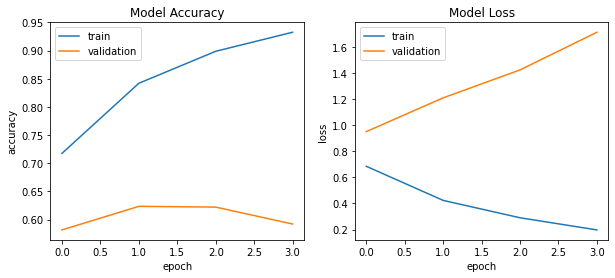

In [500]:
plot_training_hist(history)

In [501]:
# Évaluation du modèle
results = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {results[1]}")

138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5804 - loss: 0.9621 - precision_35: 0.5982 - recall_35: 0.5371
Test Accuracy: 0.5815118551254272


<!--
 Copyright 2024 ensai
 
 Licensed under the Apache License, Version 2.0 (the "License");
 you may not use this file except in compliance with the License.
 You may obtain a copy of the License at
 
     https://www.apache.org/licenses/LICENSE-2.0
 
 Unless required by applicable law or agreed to in writing, software
 distributed under the License is distributed on an "AS IS" BASIS,
 WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 See the License for the specific language governing permissions and
 limitations under the License.
-->



In [502]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test, class_names):
    '''Function to plot confusion matrix for the passed model and test data'''
    
    # Prédire les classes avec le modèle
    y_pred = model.predict(X_test)
    
    # Calculer la matrice de confusion
    cm = confusion_matrix(np.argmax(np.array(y_test), axis=1), np.argmax(y_pred, axis=1))
    
    # Tracer la matrice de confusion avec seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=class_names, yticklabels=class_names)
    
    # Titres et labels
    plt.title('Matrice de Confusion', fontsize=16)
    plt.xlabel('Étiquette Prédite', fontsize=12)
    plt.ylabel('Étiquette Réelle', fontsize=12)
    plt.show()




138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


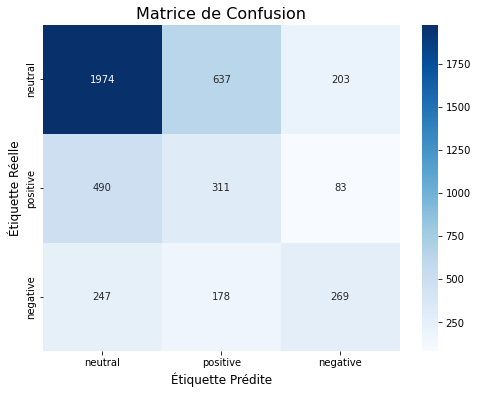

In [503]:
# Assurez-vous que 'class_names' contient les noms des classes dans l'ordre (e.g., ['negative', 'neutral', 'positive'])
class_names = data['airline_sentiment'].unique()

# Appel de la fonction avec votre modèle, jeu de test et étiquettes de classe
plot_confusion_matrix(model, x_test, y_test, class_names)

<!--
 Copyright 2024 ensai
 
 Licensed under the Apache License, Version 2.0 (the "License");
 you may not use this file except in compliance with the License.
 You may obtain a copy of the License at
 
     https://www.apache.org/licenses/LICENSE-2.0
 
 Unless required by applicable law or agreed to in writing, software
 distributed under the License is distributed on an "AS IS" BASIS,
 WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 See the License for the specific language governing permissions and
 limitations under the License.
-->



In [504]:
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences

# Sauvegarder le meilleur modèle au format natif Keras
model.save('best_model.keras')
print('Meilleur modèle sauvegardé au format Keras (.keras)')



Meilleur modèle sauvegardé au format Keras (.keras)


In [505]:
# Charger le modèle sauvegardé
from tensorflow.keras.models import load_model

model = load_model('best_model.keras')

def predict_class(text):
    '''Function to predict sentiment class of the passed text'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    max_len = 50  # La même longueur maximale utilisée lors de l'entraînement

    # Transformer le texte en séquence d'entiers à l'aide du tokenizer
    xt = tokenizer.texts_to_sequences(text)
    
    # Vérifier si le texte est valide et a bien été converti en une séquence
    if len(xt[0]) == 0:
        print("Le texte fourni est trop court ou ne contient aucun mot reconnu.")
        return
    
    # Appliquer le padding pour obtenir des séquences de même longueur
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    
    # Prédire la classe de sentiment avec le modèle chargé
    yt = model.predict(xt).argmax(axis=1)
    
    # Afficher la prédiction
    print(f'Texte : {text[0]}')
    print(f'Sentiment prédit : {sentiment_classes[yt[0]]}\n')



In [506]:
# Exemples de prédictions
predict_class(['I hate when I have to call and wake people up'])
predict_class(['The food was meh'])
predict_class(['He is the best minister India has ever seen'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Texte : I hate when I have to call and wake people up
Sentiment prédit : Negative

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Texte : The food was meh
Sentiment prédit : Neutral

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Texte : He is the best minister India has ever seen
Sentiment prédit : Positive



In [507]:
# Exemples de prédictions
test_phrases = [
    "I absolutely despise waiting in long lines.",
    "The service was terrible and I will never return.",
    "I had a horrible experience with the product.",
    "The meeting is scheduled for next Tuesday.",
    "I have a book that I read last year.",
    "Today is a cloudy day.",
    "I love this place! The ambiance is wonderful.",
    "The presentation was fantastic and very engaging.",
    "This is the best coffee I have ever tasted!"
]

for phrase in test_phrases:
    predict_class([phrase])  # Test each phrase


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Texte : I absolutely despise waiting in long lines.
Sentiment prédit : Neutral

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Texte : The service was terrible and I will never return.
Sentiment prédit : Negative

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Texte : I had a horrible experience with the product.
Sentiment prédit : Neutral

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Texte : The meeting is scheduled for next Tuesday.
Sentiment prédit : Neutral

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Texte : I have a book that I read last year.
Sentiment prédit : Neutral

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Texte : Today is a cloudy day.
Sentiment prédit : Neutral

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Texte : I love this place! The ambiance is wonderful.
Sentiment prédit : Positive

Le texte fourni est trop court ou ne contient aucun mot reconnu.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Texte : This is the best coffee I have ever tasted!
Sentiment prédit : Positive

